<a href="https://colab.research.google.com/github/diegobarrera/kaggle-ML/blob/master/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sector Atención al Cliente

"Recibimos muchas consultas de clientes a través de correo electrónico y chat. Nos gustaría poder clasificar automáticamente estas consultas por tema o urgencia para poder responder de forma más rápida y eficiente. ¿Podría la IA ayudarnos a hacerlo?"

## Cómo nos enfrentamos a un proyecto de IA?
* **Escogemos una o varias tareas a resolver**:

 Dado un texto proveniente de un correo o chat, poder clasificar la urgencia y el tema del mismo.

 **Inicialmente se hara solo la clasificacion de la urgencia**.

* **Escogemos una librería de software**

* **Creamos nuestro dataset etiquetado**:

 Idealmente el cliente podria proporcioinar ejemplos de los correos o chats, para poderlos etiquetar por **tema** y por **urgencia**.

 Dataset con labels https://huggingface.co/datasets/gorkemsevinc/customer_support_tickets

* **Escogemos n modelos**

  Debemos realizar dos clasificaciones, una para la urgencia y otra para el tema. Debido a que lo que debemos analizar es texto debemos hacer un encoding para poder crear un word embebbing y asi sea algo entendible para la maquina.
 * https://www.kaggle.com/code/yaminh/ticket-similarity-analysis-word2vec-faiss

* **Entrenamos**

* **Poner en marcha** (como quiere nuestro cliente que ejecutemos la solución)


In [1]:
import pandas as pd

df = pd.read_parquet("hf://datasets/gorkemsevinc/customer_support_tickets/data/train-00000-of-00001.parquet")

In [2]:
df.head()

,Customer Email,Product Purchased,Ticket Type,Ticket Subject,Combined Text,Ticket Priority
0,carrollallison@example.com,gopro hero,technical issue,product setup,i'm having an issue with the gopro hero. pleas...,critical
1,clarkeashley@example.com,lg smart tv,technical issue,peripheral compatibility,i'm having an issue with the lg smart tv. plea...,critical
2,gonzalestracy@example.com,dell xps,technical issue,network problem,i'm facing a problem with my dell xps. the del...,low
3,bradleyolson@example.org,microsoft office,billing inquiry,account access,i'm having an issue with the microsoft office....,low
4,bradleymark@example.com,autodesk autocad,billing inquiry,data loss,i'm having an issue with the autodesk autocad....,low


In [3]:
df.describe()

,Customer Email,Product Purchased,Ticket Type,Ticket Subject,Combined Text,Ticket Priority
count,8469,8469,8469,8469,8469,8469
unique,8320,42,5,16,8438,4
top,bsmith@example.com,canon eos,refund request,refund request,i'm having an issue with the microsoft surface...,medium
freq,4,240,1752,576,3,2192


In [4]:
df.isnull().sum()

,0
Customer Email,0
Product Purchased,0
Ticket Type,0
Ticket Subject,0
Combined Text,0
Ticket Priority,0


Dividir los datos de tests de los de train

20% - 80%

In [5]:
def preprocess(text):
    # Eliminar stop words, signos de puntuación, etc.
    # Puedes utilizar librerías como NLTK para un preprocesamiento más avanzado
    return text.lower()

df['Combined Text'] = df['Combined Text'].apply(preprocess)
df.head()

,Customer Email,Product Purchased,Ticket Type,Ticket Subject,Combined Text,Ticket Priority
0,carrollallison@example.com,gopro hero,technical issue,product setup,i'm having an issue with the gopro hero. pleas...,critical
1,clarkeashley@example.com,lg smart tv,technical issue,peripheral compatibility,i'm having an issue with the lg smart tv. plea...,critical
2,gonzalestracy@example.com,dell xps,technical issue,network problem,i'm facing a problem with my dell xps. the del...,low
3,bradleyolson@example.org,microsoft office,billing inquiry,account access,i'm having an issue with the microsoft office....,low
4,bradleymark@example.com,autodesk autocad,billing inquiry,data loss,i'm having an issue with the autodesk autocad....,low


In [6]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size] # from 0 to test_set_size
    train_indices = shuffled_indices[test_set_size:] # from test_set_size to len(data)
    # return a tuple
    return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
train_set, test_set = shuffle_and_split_data(df, 0.2)
print(len(train_set), len(test_set))

6776 1693


In [8]:
X_train = train_set['Combined Text'].values
y_priority = train_set['Ticket Priority'].values
y_type = train_set['Ticket Type'].values

# test
x_test = test_set['Combined Text'].values
y_test_priority = test_set['Ticket Priority'].values
y_test_type = test_set['Ticket Type'].values
# df_priority = df.drop(['Customer Email', 'Product Purchased', 'Ticket Subject', 'Ticket Type'], axis=1)

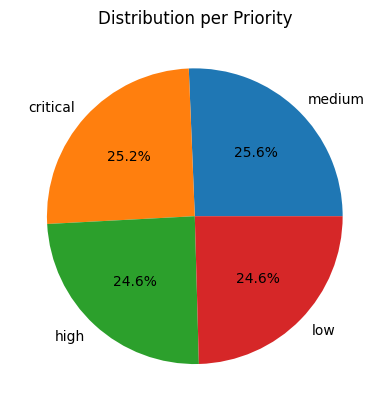

In [9]:
import matplotlib.pyplot as plt


priority_count = train_set["Ticket Priority"].value_counts()

plt.title('Distribution per Priority')
plt.pie(priority_count, labels=priority_count.index, autopct='%1.1f%%')
plt.show()



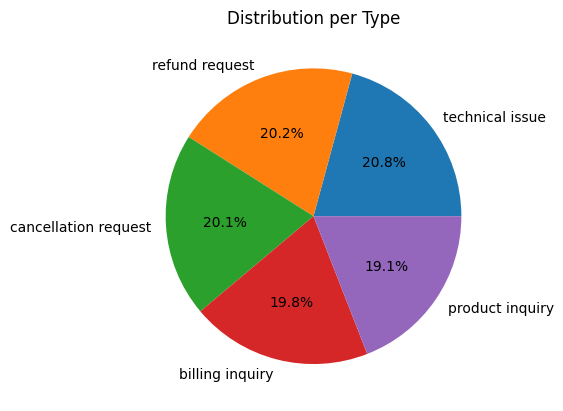

In [10]:

type_count = train_set["Ticket Type"].value_counts()

plt.title('Distribution per Type')
plt.pie(type_count, labels=type_count.index, autopct='%1.1f%%')
plt.show()

## Approach #1: Random Forest Classifier

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [12]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(X_train)

In [13]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X, y_priority)

RandomForestClassifier()

In [14]:
X_test = vectorizer.transform(x_test)
y_priority_pred = model_rf.predict(X_test)
# print(X_train)
# print(X_test)

In [15]:
fake_comment = ["This product is broken I want a refund"]
test = vectorizer.transform(fake_comment)
prediction = model_rf.predict(test)
prediction

array(['critical'], dtype=object)

In [16]:
fake_comment = ["exactly what I expected, the product is amazing!"]
test = vectorizer.transform(fake_comment)
prediction = model_rf.predict(test)
prediction

array(['critical'], dtype=object)

### Evaluar el accuracy

In [17]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_priority, y_priority_pred)
print("Accuracy RandomForestClassifier:", accuracy)

Accuracy RandomForestClassifier: 0.2262256349675133


## Approach #2 - Support Vector Machine

In [18]:
from sklearn.svm import SVC

model_SVM = SVC()
model_SVM.fit(X, y_priority)

SVC()

In [19]:
y_priority_pred = model_SVM.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test_priority, y_priority_pred)
print("Accuracy SVM:", accuracy)

Accuracy SVM: 0.24217365623154163


In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer


# vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train)

model_nb = MultinomialNB()
model_nb.fit(X, y_priority)

MultinomialNB()

In [22]:
X_test = vectorizer.transform(x_test)
y_priority_pred = model_nb.predict(X_test)

In [23]:
accuracy = accuracy_score(y_test_priority, y_priority_pred)
print("Accuracy Naive Bayes:", accuracy)

Accuracy Naive Bayes: 0.23981098641464854


## BERT Model

In [24]:
priority_mapping = {label: idx for idx, label in enumerate(df['Ticket Priority'].unique())}
df['Priority Label'] = df['Ticket Priority'].map(priority_mapping)
print("Priority Label Column Exists:", 'Priority Label' in df.columns)



Priority Label Column Exists: True


In [25]:
train_set, test_set = shuffle_and_split_data(df, 0.2)

X_train = train_set['Combined Text'].astype(str).tolist()  # Ensure texts are strings
y_train_priority = train_set['Priority Label'].values
X_test = test_set['Combined Text'].astype(str).tolist()  # Ensure texts are strings
y_test_priority = test_set['Priority Label'].values

In [26]:
from transformers import BertTokenizer, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(priority_mapping)
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
def encode_texts(texts, tokenizer):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=128)


In [28]:
train_encodings = encode_texts(X_train, tokenizer)
test_encodings = encode_texts(X_test, tokenizer)


In [31]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train_priority
)).shuffle(len(X_train)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test_priority
)).batch(32)

In [32]:
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])


In [33]:
bert_model.fit(train_dataset, validation_data=test_dataset, epochs=3)


Epoch 1/3
212/212 [==============================] - 231s 887ms/step - loss: 1.3942 - accuracy: 0.2438 - val_loss: 1.3870 - val_accuracy: 0.2617
Epoch 2/3
212/212 [==============================] - 190s 898ms/step - loss: 1.3879 - accuracy: 0.2633 - val_loss: 1.3894 - val_accuracy: 0.2493
Epoch 3/3
212/212 [==============================] - 196s 924ms/step - loss: 1.3839 - accuracy: 0.2786 - val_loss: 1.3903 - val_accuracy: 0.2558


In [34]:
loss, accuracy = bert_model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy}")

53/53 [==============================] - 15s 289ms/step - loss: 1.3903 - accuracy: 0.2558
Test Accuracy: 0.25575900077819824


In [35]:
y_priority_pred_logits = bert_model.predict(test_encodings)['logits']
y_priority_pred_classes = np.argmax(y_priority_pred_logits, axis=1)

# Calculate accuracy score using sklearn
accuracy = accuracy_score(y_test_priority, y_priority_pred_classes)
print("Test Accuracy:", accuracy)

53/53 [==============================] - 22s 307ms/step
Test Accuracy: 0.25575900767867693
